In [2]:
import numpy as np
import pandas as pd
import librosa
import os
import glob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [3]:
# Define a function to extract MFCC features with delta and delta-delta
def extract_mfcc(y, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    mfcc_combined = np.concatenate((np.mean(mfcc.T, axis=0), np.mean(mfcc_delta.T, axis=0), np.mean(mfcc_delta2.T, axis=0)))
    return mfcc_combined

In [4]:
# Data augmentation function (optional)
def augment_audio(y, sr):
    y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)  # Pitch shift
    y_stretch = librosa.effects.time_stretch(y, rate=0.8)  # Time stretching
    return [y, y_pitch, y_stretch]

In [5]:
# Load Data with optional augmentation
def load_data(dataset_path, augment=False):
    genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
    X, y = [], []
    for genre in genres:
        genre_path = os.path.join(dataset_path, genre)
        for file in glob.glob(os.path.join(genre_path, '*.wav')):
            try:
                y_audio, sr = librosa.load(file, sr=None)
                features = extract_mfcc(y_audio, sr)  # Pass y_audio and sr
                X.append(features)
                y.append(genre)
                # Augmenting data
                if augment:
                    for augmented_audio in augment_audio(y_audio, sr):
                        features_aug = extract_mfcc(augmented_audio, sr)  # Pass augmented audio and sr
                        X.append(features_aug)
                        y.append(genre)
            except Exception as e:
                print(f"Error loading file {file}: {e}")
    return np.array(X), np.array(y)

In [7]:
# 3. Prepare Data
dataset_path = 'Dataset/GTZAN/genres_original/'  # Replace with your GTZAN dataset path
X, y = load_data(dataset_path, augment=True)  # Set augment to True to enable data augmentation

In [8]:
# 4. Feature scaling and dimensionality reduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

In [9]:
# 5. Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify= y)

In [113]:
# 6. Naive Bayes Classifier
nb_model = GaussianNB(var_smoothing=1e-2)
nb_model.fit(X_train, y_train)

GaussianNB(var_smoothing=0.01)

In [111]:
# 7. SVM Classifier with hyperparameter tuning
# svm_param_grid = {
#     'C': [0.1, 1, 10, 100, 1000],
#     'gamma': ['scale', 'auto', 0.01, 0.1, 1],
#     'kernel': ['rbf', 'poly', 'sigmoid']
# }

# svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=5, n_jobs=-1)
# svm_grid.fit(X_train, y_train)
# svm_best = svm_grid.best_estimator_

svm_param_grid = {
    'C': [10],
    'gamma': [0.07],
    'kernel': ['rbf']
}

svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=5, n_jobs=-1)
svm_grid.fit(X_train, y_train)
svm_best = svm_grid.best_estimator_

In [78]:
# # 8. Voting Classifier (Ensemble of Naive Bayes and SVM)
# voting_model = VotingClassifier(estimators=[
#     ('nb', nb_model),
#     ('svm', svm_best)
# ], voting='hard')  # 'hard' voting for majority class, 'soft' for probabilistic

# voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('svm', SVC(C=10, gamma='auto'))])

In [114]:
# 9. Evaluate Models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision_macro = report['macro avg']['precision']
    recall_macro = report['macro avg']['recall']
    f1_macro = report['macro avg']['f1-score']
    
    print(f"Performance of {model_name}")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    return accuracy, precision_macro, recall_macro, f1_macro, y_pred

# Evaluasi model Naive Bayes
accuracy_nb, precision_nb_macro, recall_nb_macro, f1_nb_macro, y_pred_nb = evaluate_model(nb_model, X_test, y_test, "Naive Bayes")

# Evaluasi model SVM
accuracy_svm, precision_svm_macro, recall_svm_macro, f1_svm_macro, y_pred_svm = evaluate_model(svm_best, X_test, y_test, "SVM (tuned)")



Performance of Naive Bayes
Accuracy: 0.50375
Classification Report:
               precision    recall  f1-score   support

       blues       0.50      0.26      0.34        80
   classical       0.81      0.81      0.81        80
     country       0.33      0.31      0.32        80
       disco       0.38      0.33      0.35        80
      hiphop       0.56      0.46      0.51        80
        jazz       0.38      0.50      0.43        80
       metal       0.60      0.89      0.72        80
         pop       0.56      0.70      0.62        80
      reggae       0.48      0.38      0.42        80
        rock       0.39      0.40      0.40        80

    accuracy                           0.50       800
   macro avg       0.50      0.50      0.49       800
weighted avg       0.50      0.50      0.49       800

Performance of SVM (tuned)
Accuracy: 0.9525
Classification Report:
               precision    recall  f1-score   support

       blues       0.96      0.94      0.95      

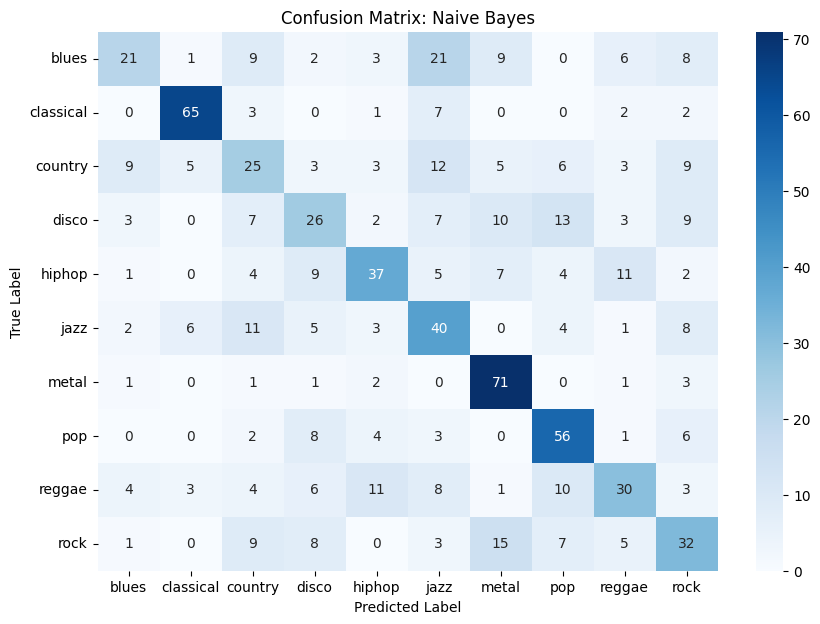

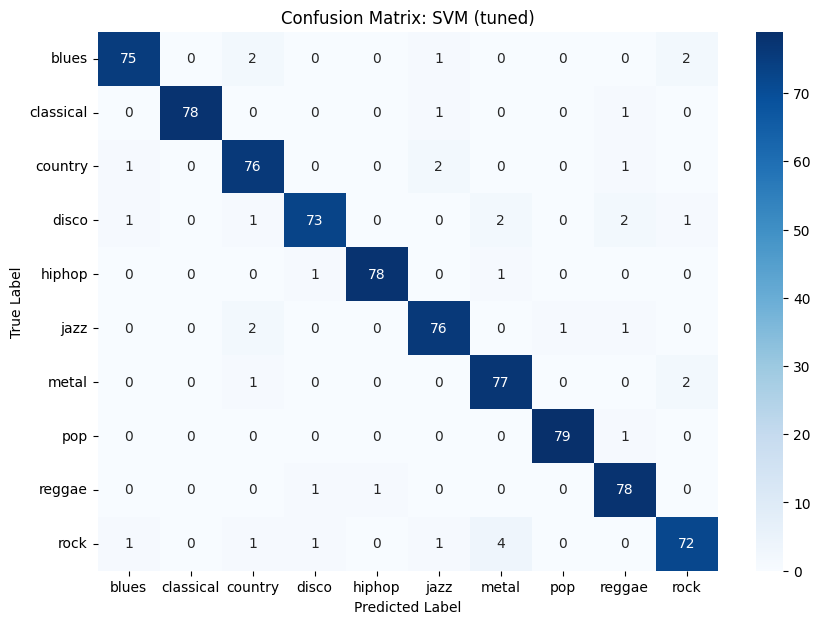

In [115]:
# 9. Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=genres, yticklabels=genres)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot Confusion Matrix for each model
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")
plot_confusion_matrix(y_test, y_pred_svm, "SVM (tuned)")

In [116]:
# 11. Save results into DataFrame
results = {
    'Model': ['Naive Bayes', 'SVM (tuned)'],
    'Accuracy': [accuracy_nb, accuracy_svm],
    'Macro Avg Precision': [precision_nb_macro, precision_svm_macro],
    'Macro Avg Recall': [recall_nb_macro, recall_svm_macro],
    'Macro Avg F1-Score': [f1_nb_macro, f1_svm_macro],
}

results_df = pd.DataFrame(results)

# Show results
print(results_df)

         Model  Accuracy  Macro Avg Precision  Macro Avg Recall  \
0  Naive Bayes   0.50375             0.499428           0.50375   
1  SVM (tuned)   0.95250             0.953114           0.95250   

   Macro Avg F1-Score  
0            0.492169  
1            0.952529  


In [118]:
# Save the models and scaler
joblib.dump(nb_model, 'naive_bayes_model.pkl')
joblib.dump(svm_best, 'svm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')

print("Models saved successfully!")

Models saved successfully!
